<a href="https://colab.research.google.com/github/surabhipandey18/Instrument-Classification/blob/main/Instrument_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import sklearn as sk
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [3]:
#set seeds
tf.random.set_seed(42)

In [4]:
#file path
file_path = '/content/drive/MyDrive/DL study/music_instruments'

In [5]:
#image and batch size
img_size = (224, 224)
batch_size = 32

In [6]:
#genrate the training and validation data
training_data_generator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)   #describe the generator

training_generator = training_data_generator.flow_from_directory(
    file_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)  #training dataset

validation_generator = training_data_generator.flow_from_directory(
    file_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)  #validation data generated

Found 1448 images belonging to 10 classes.
Found 358 images belonging to 10 classes.


In [7]:
#name of the classes
class_names = list(training_generator.class_indices.keys())
print(class_names)

['accordion', 'banjo', 'drum', 'flute', 'guitar', 'harmonica', 'saxophone', 'sitar', 'tabla', 'violin']


<Figure size 1000x1000 with 0 Axes>

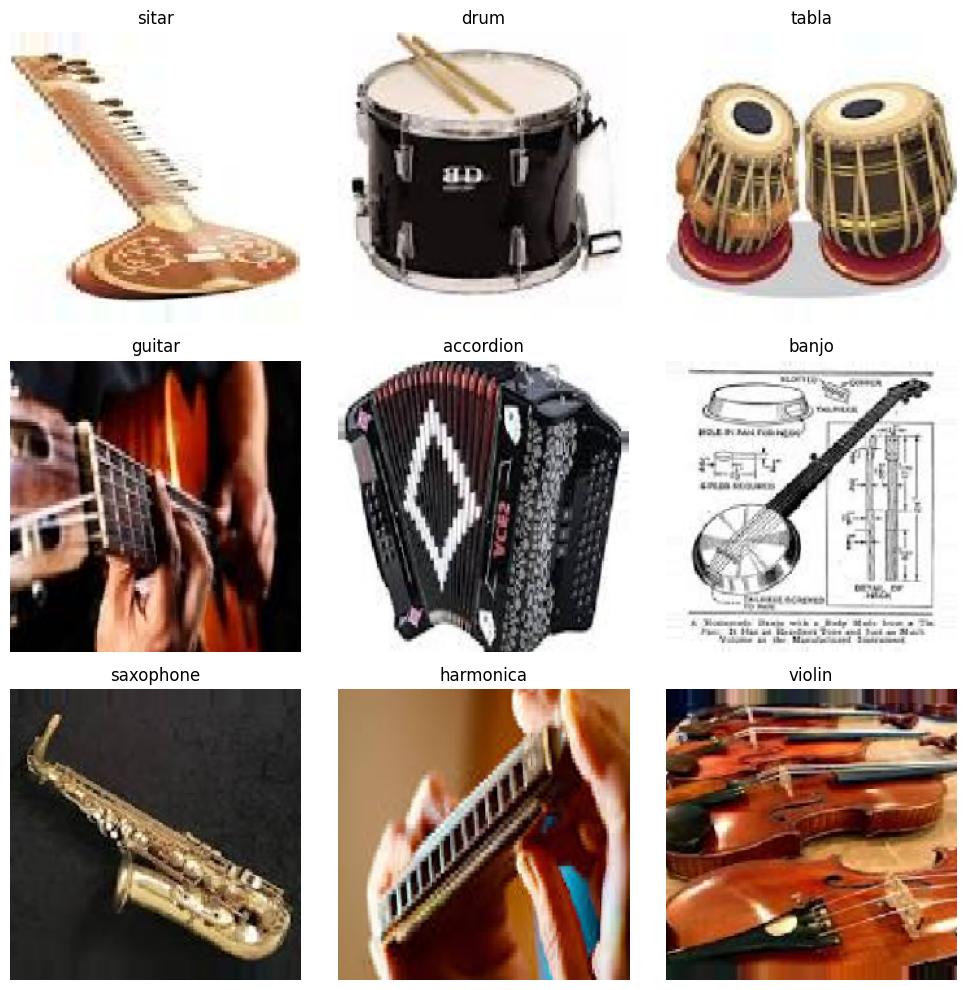

In [8]:
#different class images
images, labels = next(training_generator)

images_per_class = {}

plt.figure(figsize=(10, 10)) #Class name in figure
for i in range(images.shape[0]):
    predicted_class_index = class_names[np.argmax(labels[i])]
    predicted_class = class_names[np.argmax(labels[i])]
    if predicted_class not in images_per_class:
        images_per_class[predicted_class] = images[i]
    if len(images_per_class) == len(class_names):
        break
plt.figure(figsize=(10, 10)) #image figure
i = 1
for class_name, images in images_per_class.items():
  num_classes = len(images_per_class)
  num_cols = int(np.ceil(np.sqrt(num_classes)))
  num_rows = int(np.ceil(num_classes / num_cols))

  plt.subplot(num_rows, num_cols, i)
  plt.imshow(images)
  plt.title(class_name)
  plt.axis('off')
  i += 1
plt.tight_layout()
plt.show()


In [9]:
#model CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,250 (42.61 MB)

 Trainable params: 11,170,250 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
#shift to tpu
device = tf.device('/device:GPU:0')

In [12]:
#train the model
with tf.device('/device:GPU:0'):
  history = model.fit(
      training_generator,
      steps_per_epoch=training_generator.samples // batch_size,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples // batch_size)

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 543s 12s/step - accuracy: 0.1134 - loss: 2.7447 - val_accuracy: 0.2415 - val_loss: 2.1566
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.2500 - loss: 2.1725 - val_accuracy: 0.2273 - val_loss: 2.1394
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 920ms/step - accuracy: 0.2366 - loss: 2.1410 - val_accuracy: 0.3835 - val_loss: 1.8856
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.4375 - loss: 1.7946 - val_accuracy: 0.3778 - val_loss: 1.9354
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 61s 588ms/step - accuracy: 0.3061 - loss: 1.9635 - val_accuracy: 0.4432 - val_loss: 1.7730
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - accuracy: 0.2500 - loss: 2.0330 - val_accuracy: 0.4205 - val_loss: 1.7914
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 810ms/step - accuracy: 0.3731 - loss: 1.8259 - val_accuracy: 0.4773 - val_loss: 1.6350
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.5312 - loss: 1.6392 - val_accuracy:

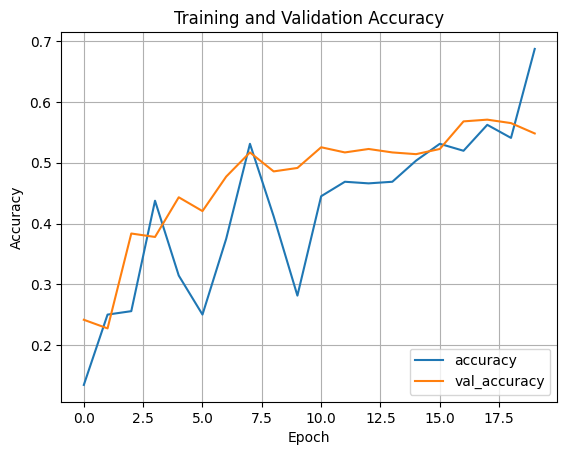

In [27]:
#accuracy graph
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

46/46 ━━━━━━━━━━━━━━━━━━━━ 22s 473ms/step


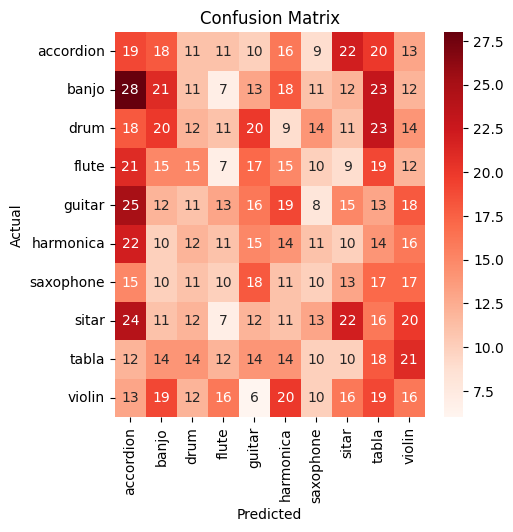

CNN Training Accuracy: 0.6875
CNN Validation Accuracy: 0.5482954382896423


In [16]:
#accuracy score and confusion matrix
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

cf = confusion_matrix(training_generator.classes, np.argmax(model.predict(training_generator), axis=-1))

plt.figure(figsize=(5, 5))
sns.heatmap(cf, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print('CNN Training Accuracy:', accuracy[-1])
print('CNN Validation Accuracy:', val_accuracy[-1])

In [18]:
#transfer learning preprocessing
tl_data_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [19]:
#transfer learning model
tl_training_generator = tl_data_generator.flow_from_directory(
    file_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

tl_validation_generator = tl_data_generator.flow_from_directory(
    file_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 1448 images belonging to 10 classes.
Found 358 images belonging to 10 classes.


In [22]:
#tl model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

tl_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(len(class_names), activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

tl_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [25]:
#train tl model
with tf.device('/device:GPU:0'):
  tl_history = tl_model.fit(
      tl_training_generator,
      steps_per_epoch=tl_training_generator.samples // batch_size,
      validation_data = tl_validation_generator,
      validation_steps=tl_validation_generator.samples // batch_size,
      epochs=20)

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 250ms/step - accuracy: 0.1313 - loss: 2.2011 - val_accuracy: 0.3068 - val_loss: 1.9397
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.1875 - loss: 2.0580 - val_accuracy: 0.3068 - val_loss: 1.9394
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 214ms/step - accuracy: 0.2235 - loss: 1.9881 - val_accuracy: 0.4886 - val_loss: 1.6018
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.2812 - loss: 1.6163 - val_accuracy: 0.4830 - val_loss: 1.6018
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 275ms/step - accuracy: 0.2630 - loss: 1.8453 - val_accuracy: 0.5625 - val_loss: 1.5157
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.1875 - loss: 2.0630 - val_accuracy: 0.5682 - val_loss: 1.5078
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 216ms/step - accuracy: 0.3156 - loss: 1.7190 - val_accuracy: 0.6051 - val_loss: 1.3901
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.2500 - loss: 1.7822 - val_accuracy: 0.

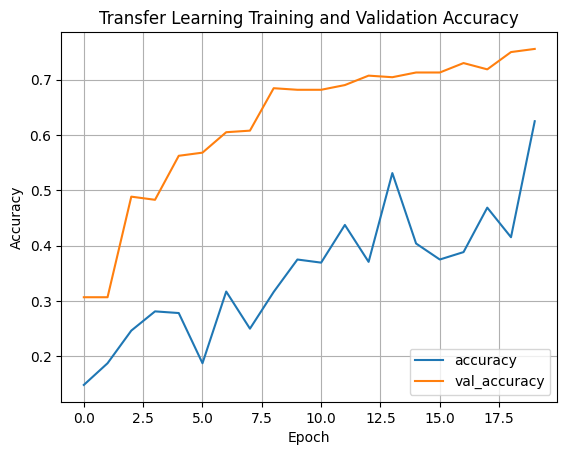

In [29]:
#accuracy graph for transfer learning model
plt.plot(tl_history.history['accuracy'], label='accuracy')
plt.plot(tl_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Transfer Learning Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step


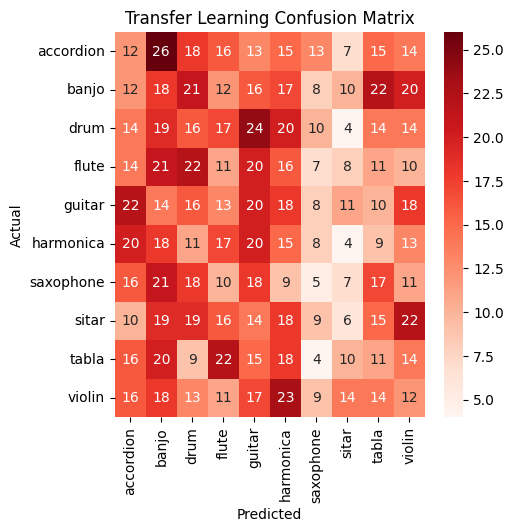

Transfer Learning Training Accuracy: 0.625
Transfer Learning Validation Accuracy: 0.7556818127632141


In [34]:
#accuarcy score and confusion matrix
accuracy = tl_history.history['accuracy']
val_accuracy = tl_history.history['val_accuracy']

cf = confusion_matrix(tl_training_generator.classes, np.argmax(tl_model.predict(tl_training_generator), axis = -1))
plt.figure(figsize=(5, 5))
sns.heatmap(cf, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Transfer Learning Confusion Matrix')
plt.show()
print('Transfer Learning Training Accuracy:', accuracy[-1])
print('Transfer Learning Validation Accuracy:', val_accuracy[-1])


In [36]:
#save model
tl_model.save('instrument_modelling.keras')